# SIMULACIÓN PV Y ANALISIS DE SENSIBILIDAD

NOTA:
    Para observar todos los gráficos a la ves, visite http://127.0.0.1:8050/

In [1]:
#!/usr/bin/env python3
"""
Simulación de sistema fotovoltaico para múltiples países usando PySAM
Este script realiza simulaciones de sistemas fotovoltaicos para Chile, China y Sudáfrica
con diferentes capacidades de sistema
"""

import PySAM.Pvwattsv7 as pv
import PySAM.Lcoefcr as Lcoefcr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path


 # Definición de funciones
 Función para Simulación Comparativa Energía Anual vs Capacidad

In [2]:

def simular_comparativa_energia_capacidad(paises, plantas, output_dir_graphs, output_dir_results):
    """
    Realiza simulaciones PVWatts para diferentes países y capacidades de planta,
    generando un gráfico comparativo de Energía Anual vs Capacidad y guardando
    los resultados numéricos en un archivo CSV.
    Args:
        paises (list): Lista de diccionarios, cada uno con información del país 
                       (nombre, archivo de recurso solar, color para gráfico).
        plantas (list): Lista de diccionarios, cada uno con parámetros de una 
                        configuración de planta (nombre, capacity_kw, dc_ac_ratio, tilt).
        output_dir_graphs (str): Ruta al directorio donde guardar el gráfico generado.
        output_dir_results (str): Ruta al directorio donde guardar el archivo CSV con resultados.
    Returns:
        None: La función guarda el gráfico y el CSV directamente.
    """
    print("\n--- Iniciando Simulación Comparativa Energía Anual vs Capacidad ---")
    resultados_simulacion = [] # Lista para acumular los resultados de todas las simulaciones

    # Iterar sobre cada país para la simulación comparativa
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        solar_resource_file = pais_info["archivo"]
        color_pais = pais_info["color"]

        # Determinar Azimut óptimo según el hemisferio
        # Hemisferio Sur (Chile, Australia): paneles hacia el Norte (0°)
        # Hemisferio Norte (España): paneles hacia el Sur (180°)
        if pais_nombre in ["chile", "australia"]:
            azimuth_correcto = 0
        else:
            azimuth_correcto = 180

        print(f"  Simulando para {pais_nombre.capitalize()} (Azimuth: {azimuth_correcto}°)...")
        # Iterar sobre cada configuración de planta definida en la lista 'plantas'
        for p in plantas:
            try:
                # Crear una nueva instancia del modelo PVWatts
                pv_model = pv.new()
                # Asignar archivo de recurso solar
                pv_model.SolarResource.solar_resource_file = solar_resource_file
                # Configurar parámetros del sistema desde la configuración de la planta 'p'
                pv_model.SystemDesign.system_capacity = p["capacity_kw"]
                pv_model.SystemDesign.dc_ac_ratio = p["dc_ac_ratio"]
                pv_model.SystemDesign.array_type = 1
                pv_model.SystemDesign.azimuth = azimuth_correcto # Azimut según hemisferio
                pv_model.SystemDesign.tilt = p["tilt"] # Inclinación fija para esta comparativa
                pv_model.SystemDesign.gcr = 0.4 # Ground Coverage Ratio (Ratio de Cobertura del Suelo)
                pv_model.SystemDesign.inv_eff = 96 # Eficiencia del inversor (%)
                pv_model.SystemDesign.losses = 14.0 # Pérdidas totales del sistema (%)
                pv_model.AdjustmentFactors.constant = 0 # Factor de ajuste constante (pérdidas/ganancias)

                # Ejecutar simulación PVWatts
                pv_model.execute()

                # Obtener la energía anual [kWh]
                annual_energy = pv_model.Outputs.annual_energy

                # Guardar resultados en la lista general
                resultados_simulacion.append({
                    "pais": pais_nombre.capitalize(),
                    "capacidad_kw": p["capacity_kw"],
                    "energia_kwh": annual_energy,
                    "color": color_pais
                })
                # print(f"    - {p['nombre']}: {annual_energy:.2f} kWh") # Opcional:  Descomentar para ver salida detallada

            except Exception as e:
                # Manejar posibles errores durante la simulación para una configuración específica
                print(f"      Error simulando {p['nombre']} para {pais_nombre}: {e}")
                # Añadir un resultado de error (energía 0) para no romper el gráfico/análisis
                resultados_simulacion.append({
                    "pais": pais_nombre.capitalize(),
                    "capacidad_kw": p["capacity_kw"],
                    "energia_kwh": 0, # Marcar como 0 o np.nan si hubo error
                    "color": color_pais
                })
    print("------------Gráfico de comparación de energía anual vs capacidad------------")
    # Generar el gráfico comparativo solo si se obtuvieron resultados
    if resultados_simulacion:
        plt.figure(figsize=(10, 6))

        # Agrupar resultados por país para dibujar una línea por cada uno
        paises_unicos = sorted(list(set(res["pais"] for res in resultados_simulacion))) # Ordenar países
        for pais in paises_unicos:
            # Filtrar datos para el país actual
            datos_pais = [res for res in resultados_simulacion if res["pais"] == pais]
            # Ordenar por capacidad para que la línea se dibuje correctamente
            datos_pais.sort(key=lambda x: x["capacidad_kw"])
            # Extraer capacidades y energías para el gráfico
            capacidades = [res["capacidad_kw"] for res in datos_pais]
            energias = [res["energia_kwh"] for res in datos_pais]
            color = datos_pais[0]["color"] # Obtener color del primer resultado

            plt.plot(capacidades, energias, label=pais, color=color, marker='o', linestyle='-', linewidth=2, markersize=6)

        # Configuración del gráfico
        plt.xlabel("Capacidad de Planta (kW)")
        plt.ylabel("Energía Anual Generada (kWh)")
        plt.title("Energía Anual vs Capacidad de Planta por País")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Notación científica
        plt.tight_layout()

        # Guardar el gráfico
        output_filename = "pv_energia_vs_capacidad_all_countries.png"
        output_filepath = os.path.join(output_dir_graphs, output_filename) # Usa output_dir_graphs
        plt.savefig(output_filepath)
        plt.show()
        plt.close()
        print(f"\nGráfico comparativo Energía vs Capacidad guardado en: {output_filepath}")
        
        # --- Guardar los resultados numéricos en un archivo CSV --- 
        # Convertir la lista de resultados a un DataFrame de Pandas
        df_resultados = pd.DataFrame(resultados_simulacion)
        # Filtrar resultados donde la energía fue 0 (posibles errores)
        df_resultados = df_resultados[df_resultados['energia_kwh'] > 0] # Filtrar errores

        if not df_resultados.empty:
            output_csv_filename = "resultados_pv_energia_vs_capacidad.csv"
            # Usa output_dir_results para la ruta del CSV
            output_filepath_csv = os.path.join(output_dir_results, output_csv_filename)
            try:
                df_resultados_save = df_resultados.drop(columns=['color'], errors='ignore')
                df_resultados_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                print(f"Resultados numéricos Energía vs Capacidad guardados en: {output_filepath_csv}")
            except Exception as e:
                print(f"Error al guardar resultados numéricos Energía vs Capacidad: {e}")
        else:
             print("\nNo se generaron resultados válidos para guardar en CSV de Energía vs Capacidad.")
    else:
        print("\nNo se generaron resultados para el gráfico Energía vs Capacidad.")

Función para Análisis de Sensibilidad de Inclinación (Tilt)

In [3]:
def analizar_sensibilidad_inclinacion(paises, output_dir_graphs, output_dir_results, config):
    """
    Realiza un análisis de sensibilidad variando la inclinación de los paneles (tilt)
    para una configuración de planta PV fija (definida en 'config') en cada uno
    de los países especificados.
    Genera un gráfico combinado mostrando la Energía Anual vs Tilt para todos los países
    y guarda los resultados numéricos en un archivo CSV.

    Args:
        paises (list): Lista de diccionarios con información de los países.
        output_dir_graphs (str): Directorio para guardar el gráfico.
        output_dir_results (str): Directorio para guardar el archivo CSV.
        config (dict): Diccionario con los parámetros fijos de la planta PV para
                       el análisis de sensibilidad (capacity_kw, dc_ac_ratio, etc.).

    Returns:
        None: Guarda gráfico y CSV.
    """
    print("\n--- Iniciando Análisis de Sensibilidad de Inclinación ---")

    # Parámetros fijos de la planta tomados del diccionario 'config'
    # Se usan valores por defecto si no se encuentran en el diccionario
    sens_capacity_kw = config.get("capacity_kw", 1000.0)
    sens_dc_ac_ratio = config.get("dc_ac_ratio", 1.2)
    sens_gcr = config.get("gcr", 0.4)
    sens_inv_eff = config.get("inv_eff", 96)
    sens_losses = config.get("losses", 14.0)
    sens_adjust_constant = config.get("adjust_constant", 0)
    sens_array_type = config.get("array_type", 1)

    # Definir el rango de ángulos de inclinación a evaluar (de 0 a 90 grados, en pasos de 5)
    tilt_angles = np.arange(0, 91, 5)
    tilt_sensitivity_results_all = [] # Lista para todos los resultados de sensibilidad

    # Iterar sobre cada país
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        sens_solar_resource_file = pais_info["archivo"]
        color_pais = pais_info["color"]

        # Determinar Azimut correcto según hemisferio
        if pais_nombre in ["chile", "australia"]: # Hemisferio Sur
            sens_azimuth = 0
        else: # Hemisferio Norte (España)
            sens_azimuth = 180

        print(f"  Calculando sensibilidad de inclinación para {pais_nombre.capitalize()} (Azimuth: {sens_azimuth}°)...")

        # Iterar sobre cada ángulo de inclinación
        for tilt in tilt_angles:
            try:
                # Crear modelo PVWatts para esta simulación específica
                pv_sens_model = pv.new()
                pv_sens_model.SolarResource.solar_resource_file = sens_solar_resource_file
                # Asignar parámetros fijos de la configuración
                pv_sens_model.SystemDesign.system_capacity = sens_capacity_kw
                pv_sens_model.SystemDesign.dc_ac_ratio = sens_dc_ac_ratio
                pv_sens_model.SystemDesign.array_type = sens_array_type
                pv_sens_model.SystemDesign.azimuth = sens_azimuth
                # Asignar la inclinación actual del bucle
                pv_sens_model.SystemDesign.tilt = float(tilt)
                pv_sens_model.SystemDesign.gcr = sens_gcr
                pv_sens_model.SystemDesign.inv_eff = sens_inv_eff
                pv_sens_model.SystemDesign.losses = sens_losses
                pv_sens_model.AdjustmentFactors.constant = sens_adjust_constant

                # Ejecutar simulación
                pv_sens_model.execute()
                # Obtener resultado de energía anual
                annual_energy_tilt = pv_sens_model.Outputs.annual_energy

                # Guardar resultados en la lista general
                tilt_sensitivity_results_all.append({
                    "pais": pais_nombre.capitalize(),
                    "tilt": tilt,
                    "energia_kwh": annual_energy_tilt,
                    "color": color_pais
                })
            except Exception as e:
                # Manejar errores para una inclinación específica
                print(f"    Error en Tilt {tilt}° para {pais_nombre}: {e}")
                # Añadir resultado de error (energía 0)
                tilt_sensitivity_results_all.append({
                    "pais": pais_nombre.capitalize(), "tilt": tilt, "energia_kwh": 0, "color": color_pais
                })
    print("---------------------Gráfico de sensibilidad de inclinación-------------------")
    # Generar gráfico combinado solo si hay resultados
    if tilt_sensitivity_results_all:
        plt.figure(figsize=(10, 6))

        # Agrupar por país para graficar líneas separadas
        paises_sens_unicos = sorted(list(set(res["pais"] for res in tilt_sensitivity_results_all)))
        for pais in paises_sens_unicos:
            # Filtrar y ordenar datos del país actual
            datos_pais = [res for res in tilt_sensitivity_results_all if res["pais"] == pais]
            datos_pais.sort(key=lambda x: x["tilt"])

            tilts = [res["tilt"] for res in datos_pais]
            energias = [res["energia_kwh"] for res in datos_pais]
            color = datos_pais[0]["color"]

            # Dibujar línea para este país
            plt.plot(tilts, energias, marker='o', linestyle='-', color=color, label=pais, linewidth=2, markersize=5) # Tamaño marcador reducido

        # Configuración del gráfico
        plt.xlabel("Ángulo de Inclinación (grados)")
        plt.ylabel("Energía Anual Generada (kWh)")
        plt.title(f"Sensibilidad Energía Anual a Inclinación ({sens_capacity_kw} kW)")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Notación científica eje Y
        plt.tight_layout()

        # Guardar el gráfico
        tilt_sens_filename = f"tilt_sensitivity_all_countries_{int(sens_capacity_kw)}kW.png"
        tilt_sens_filepath = os.path.join(output_dir_graphs, tilt_sens_filename)
        plt.savefig(tilt_sens_filepath)
        plt.show() # Mostrar gráfico
        plt.close() # Cerrar figura
        print(f"\nGráfico de sensibilidad de inclinación guardado en: {tilt_sens_filepath}")

        # --- Guardar resultados numéricos en CSV ---
        df_tilt_results = pd.DataFrame(tilt_sensitivity_results_all)
        # Filtrar posibles errores donde la energía es 0
        df_tilt_results = df_tilt_results[df_tilt_results['energia_kwh'] > 0]
        if not df_tilt_results.empty:
            # Nombre del archivo CSV (incluye capacidad para identificarlo)
            output_csv_filename = f"resultados_pv_sensibilidad_tilt_{int(sens_capacity_kw)}kW.csv"
            # Construir ruta completa en directorio de resultados
            output_filepath_csv = os.path.join(output_dir_results, output_csv_filename)
            try:
                # Quitar columna 'color' antes de guardar
                df_tilt_save = df_tilt_results.drop(columns=['color'], errors='ignore')
                df_tilt_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                print(f"Resultados numéricos Sensibilidad Inclinación guardados en: {output_filepath_csv}")
            except Exception as e:
                print(f"Error al guardar resultados numéricos Sensibilidad Inclinación: {e}")
        else:
             print("\nNo se generaron resultados válidos para guardar en CSV de Sensibilidad Inclinación.")
        # --- Fin Guardar CSV ---
    else:
        print("\nNo se generaron resultados para el gráfico de sensibilidad de inclinación.")

Función para Comparación de Azimut (0° vs 180°)

In [4]:
def comparar_azimut(paises, output_dir_graphs, output_dir_results, config):
    """
    Compara la generación de energía anual para azimut 0° (Norte) y 180° (Sur)
    para una configuración de planta PV fija (definida en 'config') en cada uno 
    de los países especificados.
    Genera un gráfico de barras agrupadas mostrando la comparación por país y 
    guarda los resultados numéricos en un archivo CSV.

    Args:
        paises (list): Lista de diccionarios con información de los países.
        output_dir_graphs (str): Directorio para guardar el gráfico.
        output_dir_results (str): Directorio para guardar el archivo CSV.
        config (dict): Diccionario con los parámetros fijos de la planta PV para 
                       la comparación (capacity_kw, tilt, etc.).

    Returns:
        None: Guarda gráfico y CSV.
    """
    print("\n--- Iniciando Comparación de Azimut (0° vs 180°) ---")

    # Parámetros fijos de la planta tomados del diccionario 'config'
    az_comp_capacity_kw = config.get("capacity_kw", 1000.0)
    az_comp_tilt = config.get("tilt", 20.0)
    az_comp_dc_ac_ratio = config.get("dc_ac_ratio", 1.2)
    az_comp_gcr = config.get("gcr", 0.4)
    az_comp_inv_eff = config.get("inv_eff", 96)
    az_comp_losses = config.get("losses", 14.0)
    az_comp_adjust_constant = config.get("adjust_constant", 0)
    az_comp_array_type = config.get("array_type", 1)
    azimuth_values = [0, 180] # Valores de azimut a comparar (0=Norte, 180=Sur)

    azimuth_comparison_results = [] # Lista para acumular resultados

    # Iterar sobre cada país y cada valor de azimut
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        az_comp_solar_file = pais_info["archivo"]
        print(f"  Calculando comparación de azimut para {pais_nombre.capitalize()}...")

        for az in azimuth_values:
            try:
                # Crear modelo PVWatts
                pv_az_model = pv.new()
                pv_az_model.SolarResource.solar_resource_file = az_comp_solar_file
                # Configurar parámetros fijos y el azimut actual
                pv_az_model.SystemDesign.system_capacity = az_comp_capacity_kw
                pv_az_model.SystemDesign.dc_ac_ratio = az_comp_dc_ac_ratio
                pv_az_model.SystemDesign.array_type = az_comp_array_type
                pv_az_model.SystemDesign.azimuth = float(az) # Azimut actual
                pv_az_model.SystemDesign.tilt = az_comp_tilt
                pv_az_model.SystemDesign.gcr = az_comp_gcr
                pv_az_model.SystemDesign.inv_eff = az_comp_inv_eff
                pv_az_model.SystemDesign.losses = az_comp_losses
                pv_az_model.AdjustmentFactors.constant = az_comp_adjust_constant

                # Ejecutar y obtener energía
                pv_az_model.execute()
                annual_energy_az = pv_az_model.Outputs.annual_energy

                # Guardar resultado
                azimuth_comparison_results.append({
                    "pais": pais_nombre.capitalize(),
                    "azimuth": az,
                    "energia_kwh": annual_energy_az
                })
                # print(f"    - Azimuth {az}°: {annual_energy_az:.2f} kWh") # Opcional
            except Exception as e:
                # Manejar errores
                print(f"      Error en Azimuth {az}° para {pais_nombre}: {e}")
                azimuth_comparison_results.append({
                    "pais": pais_nombre.capitalize(), "azimuth": az, "energia_kwh": 0
                })
    print("----------------------------Gráfico de comparación de azimut----------------------------")
    # Generar gráfico de barras agrupadas si hay resultados
    if azimuth_comparison_results:
        # Convertir resultados a DataFrame y pivotar para graficar fácilmente
        df_az = pd.DataFrame(azimuth_comparison_results)
        # Pivotar: índice = país, columnas = azimut (0 y 180), valores = energía
        pivot_df_az = df_az.pivot(index='pais', columns='azimuth', values='energia_kwh').sort_index() # Ordenar por nombre de país

        n_paises = len(pivot_df_az.index) # Número de países
        bar_width = 0.35 # Ancho de las barras
        index = np.arange(n_paises) # Posiciones de los grupos de barras en el eje X

        fig, ax = plt.subplots(figsize=(10, 6))
        # Barras para Azimut 0° (Norte)
        bar1 = ax.bar(index - bar_width/2, pivot_df_az[0], bar_width, label='Azimut 0° (Norte)')
        # Barras para Azimut 180° (Sur)
        bar2 = ax.bar(index + bar_width/2, pivot_df_az[180], bar_width, label='Azimut 180° (Sur)')

        # Configuración del gráfico
        ax.set_xlabel('País')
        ax.set_ylabel('Energía Anual Generada (kWh)')
        ax.set_title(f'Comparación Energía Anual por Azimut ({az_comp_capacity_kw} kW, Tilt {az_comp_tilt}°)')
        ax.set_xticks(index) # Poner etiquetas de país en las posiciones correctas
        ax.set_xticklabels(pivot_df_az.index)
        ax.legend()
        ax.grid(True, axis='y', linestyle='--')
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Notación científica eje Y

        fig.tight_layout()

        # Guardar el gráfico
        az_comp_filename = f"azimuth_comparison_{int(az_comp_capacity_kw)}kW_tilt{int(az_comp_tilt)}.png"
        az_comp_filepath = os.path.join(output_dir_graphs, az_comp_filename)
        plt.savefig(az_comp_filepath)
        plt.show()
        plt.close()
        print(f"\nGráfico de comparación de azimut guardado en: {az_comp_filepath}")

        # --- Guardar resultados numéricos en CSV ---
        if not df_az.empty:
            # Filtrar posibles errores
            df_az_save = df_az[df_az['energia_kwh'] > 0]
            if not df_az_save.empty:
                output_csv_filename = f"resultados_pv_comparacion_azimut_{int(az_comp_capacity_kw)}kW_tilt{int(az_comp_tilt)}.csv"
                output_filepath_csv = os.path.join(output_dir_results, output_csv_filename)
                try:
                    # Guardar DataFrame (ya tiene las columnas necesarias)
                    df_az_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                    print(f"Resultados numéricos Comparación Azimut guardados en: {output_filepath_csv}")
                except Exception as e:
                    print(f"Error al guardar resultados numéricos Comparación Azimut: {e}")
            else:
                 print("\nNo se generaron resultados válidos para guardar en CSV de Comparación Azimut.")
        # --- Fin Guardar CSV ---

    else:
        print("\nNo se generaron resultados para el gráfico de comparación de azimut.")


Función para Análisis de Sensibilidad del Ratio DC/AC

In [5]:
def analizar_sensibilidad_dcac(paises, output_dir_graphs, output_dir_results, config):
    """
    Realiza un análisis de sensibilidad variando el ratio DC/AC para una
    configuración de planta PV fija (definida en 'config') en cada uno de los
    países especificados.
    Genera un gráfico combinado mostrando la Energía Anual vs Ratio DC/AC para
    todos los países, marcando el punto de máxima energía para cada uno, y guarda
    los resultados numéricos en un archivo CSV.

    Args:
        paises (list): Lista de diccionarios con información de los países.
        output_dir_graphs (str): Directorio para guardar el gráfico.
        output_dir_results (str): Directorio para guardar el archivo CSV.
        config (dict): Diccionario con los parámetros fijos de la planta PV
                       (capacity_kw, tilt, etc.).

    Returns:
        None: Guarda gráfico y CSV.
    """
    print("\n--- Iniciando Análisis de Sensibilidad del Ratio DC/AC ---")

    # Parámetros fijos de la planta tomados de 'config'
    dcac_sens_capacity_kw = config.get("capacity_kw", 1000.0)
    dcac_sens_tilt = config.get("tilt", 20.0)
    dcac_sens_gcr = config.get("gcr", 0.4)
    dcac_sens_inv_eff = config.get("inv_eff", 96)
    dcac_sens_losses = config.get("losses", 14.0)
    dcac_sens_adjust_constant = config.get("adjust_constant", 0)
    dcac_sens_array_type = config.get("array_type", 1)

    # Definir el rango de ratios DC/AC a evaluar (de 1.0 a 2.0, en pasos de 0.05)
    dc_ac_ratios = np.arange(1.0, 2.01, 0.05)
    dcac_sensitivity_results = [] # Lista para acumular resultados

    # Iterar sobre cada país
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        dcac_sens_solar_file = pais_info["archivo"]
        color_pais = pais_info["color"]

        # Determinar Azimut correcto según hemisferio
        if pais_nombre in ["chile", "australia"]: # Hemisferio Sur
            dcac_sens_azimuth = 0
        else: # Hemisferio Norte (España)
            dcac_sens_azimuth = 180

        print(f"  Calculando sensibilidad DC/AC para {pais_nombre.capitalize()} (Azimuth: {dcac_sens_azimuth}°)...")

        # Iterar sobre cada ratio DC/AC
        for ratio in dc_ac_ratios:
            try:
                # Crear modelo PVWatts
                pv_dcac_model = pv.new()
                pv_dcac_model.SolarResource.solar_resource_file = dcac_sens_solar_file
                # Configurar parámetros fijos y el ratio DC/AC actual
                pv_dcac_model.SystemDesign.system_capacity = dcac_sens_capacity_kw
                pv_dcac_model.SystemDesign.dc_ac_ratio = round(ratio, 2) # Usar ratio actual, redondeado
                pv_dcac_model.SystemDesign.array_type = dcac_sens_array_type
                pv_dcac_model.SystemDesign.azimuth = dcac_sens_azimuth
                pv_dcac_model.SystemDesign.tilt = dcac_sens_tilt
                pv_dcac_model.SystemDesign.gcr = dcac_sens_gcr
                pv_dcac_model.SystemDesign.inv_eff = dcac_sens_inv_eff
                pv_dcac_model.SystemDesign.losses = dcac_sens_losses
                pv_dcac_model.AdjustmentFactors.constant = dcac_sens_adjust_constant

                # Ejecutar y obtener energía
                pv_dcac_model.execute()
                annual_energy_dcac = pv_dcac_model.Outputs.annual_energy

                # Guardar resultado
                dcac_sensitivity_results.append({
                    "pais": pais_nombre.capitalize(),
                    "dc_ac_ratio": ratio,
                    "energia_kwh": annual_energy_dcac,
                    "color": color_pais
                })
            except Exception as e:
                # Manejar errores
                print(f"      Error en Ratio DC/AC {ratio:.2f} para {pais_nombre}: {e}")
                # Añadir resultado de error (energía 0)
                dcac_sensitivity_results.append({
                    "pais": pais_nombre.capitalize(), "dc_ac_ratio": ratio, "energia_kwh": 0, "color": color_pais
                })
    print("----------------------------Gráfico de sensibilidad DC/AC----------------------------")
    # Generar gráfico combinado si hay resultados
    if dcac_sensitivity_results:
        plt.figure(figsize=(10, 7)) # Ajustar tamaño si es necesario

        # Agrupar por país para graficar
        paises_dcac_unicos = sorted(list(set(res["pais"] for res in dcac_sensitivity_results)))
        for pais in paises_dcac_unicos:
            # Filtrar y ordenar datos del país
            datos_pais = [res for res in dcac_sensitivity_results if res["pais"] == pais]
            datos_pais.sort(key=lambda x: x["dc_ac_ratio"])

            ratios = [res["dc_ac_ratio"] for res in datos_pais]
            energias = [res["energia_kwh"] for res in datos_pais]
            color = datos_pais[0]["color"]

            # Dibujar línea para este país
            plt.plot(ratios, energias, marker='.', linestyle='-', color=color, label=pais, linewidth=2, markersize=6)

            # Marcar el punto de máxima energía para este país
            if energias and max(energias) > 0:
                max_energia = max(energias)
                try:
                    max_index = energias.index(max_energia) # Encontrar índice del máximo
                    max_ratio = ratios[max_index] # Ratio correspondiente al máximo
                    # Dibujar una estrella en el punto máximo
                    plt.plot(max_ratio, max_energia, marker='*', color=color, markersize=12, linestyle='') # Sin línea para el marcador
                    # Añadir una anotación con el valor del ratio en el máximo
                    plt.annotate(f'{max_ratio:.2f}', (max_ratio, max_energia), textcoords="offset points",
                                 xytext=(0,10), ha='center', fontsize=9, color=color) # Ajustar posición texto si es necesario
                except ValueError:
                     # Puede ocurrir si la lista de energías está vacía o contiene NaNs
                     print(f"Advertencia: No se pudo encontrar el índice del máximo para {pais} en sensibilidad DC/AC")


        # Configuración del gráfico
        plt.xlabel("Ratio DC/AC")
        plt.ylabel("Energía Anual Generada (kWh)")
        plt.title(f"Sensibilidad Energía Anual a Ratio DC/AC ({dcac_sens_capacity_kw} kW, Tilt {dcac_sens_tilt}°)")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0)) # Notación científica eje Y
        plt.tight_layout()

        # Guardar el gráfico
        dcac_sens_filename = f"dcac_sensitivity_all_countries_{int(dcac_sens_capacity_kw)}kW_tilt{int(dcac_sens_tilt)}.png"
        dcac_sens_filepath = os.path.join(output_dir_graphs, dcac_sens_filename)
        plt.savefig(dcac_sens_filepath)
        plt.show() # Mostrar gráfico
        plt.close() # Cerrar figura
        print(f"\nGráfico de sensibilidad DC/AC guardado en: {dcac_sens_filepath}")

        # --- Guardar resultados numéricos en CSV ---
        df_dcac_results = pd.DataFrame(dcac_sensitivity_results)
        # Filtrar errores donde la energía es 0
        df_dcac_results = df_dcac_results[df_dcac_results['energia_kwh'] > 0]
        if not df_dcac_results.empty:
            # Nombre del archivo CSV (incluye capacidad e inclinación)
            output_csv_filename = f"resultados_pv_sensibilidad_dcac_{int(dcac_sens_capacity_kw)}kW_tilt{int(dcac_sens_tilt)}.csv"
            # Construir ruta completa
            output_filepath_csv = os.path.join(output_dir_results, output_csv_filename)
            try:
                # Quitar columna 'color' antes de guardar
                df_dcac_save = df_dcac_results.drop(columns=['color'], errors='ignore')
                df_dcac_save.to_csv(output_filepath_csv, index=False, float_format='%.2f')
                print(f"Resultados numéricos Sensibilidad DC/AC guardados en: {output_filepath_csv}")
            except Exception as e:
                print(f"Error al guardar resultados numéricos Sensibilidad DC/AC: {e}")
        else:
            print("\nNo se generaron resultados válidos para guardar en CSV de Sensibilidad DC/AC.")
        # --- Fin Guardar CSV ---
    else:
        print("\nNo se generaron resultados para el gráfico de sensibilidad DC/AC.")


Función para Análisis de LCOE vs Fixed Charge Rate (FCR)

In [6]:
def analizar_lcoe_vs_fcr(paises, output_dir_graphs, output_dir_results, config_lcoe):
    """
    Calcula y grafica el LCOE (Levelized Cost of Energy) para diferentes tasas
    de carga fija (Fixed Charge Rate - FCR) para una configuración de planta PV
    y parámetros económicos base definidos en 'config_lcoe'.
    Genera un gráfico combinado LCOE vs FCR para todos los países y guarda los
    resultados numéricos en un archivo CSV.

    Args:
        paises (list): Lista de diccionarios con información de los países.
        output_dir_graphs (str): Directorio para guardar el gráfico.
        output_dir_results (str): Directorio para guardar el archivo CSV.
        config_lcoe (dict): Diccionario con la configuración base para el cálculo
                            de LCOE (parámetros PV, costo capital, costos operativos,
                            FCR base, etc.).

    Returns:
        None: Guarda gráfico y CSV.
    """
    print("\n--- Iniciando Análisis LCOE vs FCR ---")

    # Definir el rango de FCR a evaluar (de 0.01 a 0.10, en pasos de 0.01)
    fcr_values_range = np.arange(0.01, 0.11, 0.01)

    # Lista para guardar todos los resultados del análisis LCOE vs FCR
    lcoe_fcr_results_list = []

    # Iterar sobre cada país
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        solar_resource_file = pais_info["archivo"]
        color_pais = pais_info['color']
        print(f"  Calculando LCOE vs FCR para {pais_nombre.capitalize()}...")

        # Parámetros fijos del sistema PV y económicos base tomados de 'config_lcoe'
        capacity_kw = config_lcoe.get("capacity_kw", 1000.0)
        tilt = config_lcoe.get("tilt", 20.0)
        dc_ac_ratio = config_lcoe.get("dc_ac_ratio", 1.2)
        gcr = config_lcoe.get("gcr", 0.4)
        inv_eff = config_lcoe.get("inv_eff", 96)
        losses = config_lcoe.get("losses", 14.0)
        adjust_constant = config_lcoe.get("adjust_constant", 0)
        array_type = config_lcoe.get("array_type", 1)
        capital_cost = config_lcoe.get("capital_cost", 1_000_000) # Costo de capital base
        fixed_operating_cost = config_lcoe.get("fixed_operating_cost", 50_000) # Costo fijo anual base
        variable_operating_cost = config_lcoe.get("variable_operating_cost", 0.01) # Costo variable base

        # Determinar Azimut correcto según hemisferio
        azimuth = 0 if pais_nombre in ["chile", "australia"] else 180

        try:
            # Calcular la energía anual base UNA VEZ por país, ya que no depende del FCR
            pv_model_base = pv.new()
            pv_model_base.SolarResource.solar_resource_file = solar_resource_file
            # Configurar parámetros del sistema PV
            pv_model_base.SystemDesign.system_capacity = capacity_kw
            pv_model_base.SystemDesign.dc_ac_ratio = dc_ac_ratio
            pv_model_base.SystemDesign.array_type = array_type
            pv_model_base.SystemDesign.azimuth = azimuth
            pv_model_base.SystemDesign.tilt = tilt
            pv_model_base.SystemDesign.gcr = gcr
            pv_model_base.SystemDesign.inv_eff = inv_eff
            pv_model_base.SystemDesign.losses = losses
            pv_model_base.AdjustmentFactors.constant = adjust_constant
            # Ejecutar simulación PV
            pv_model_base.execute()
            annual_energy = pv_model_base.Outputs.annual_energy

            # Verificar si la energía anual es válida
            if annual_energy <= 0:
                print(f"    Advertencia: Energía anual es 0 o negativa para {pais_nombre}. Saltando análisis LCOE.")
                # Añadir resultados NaN para este país si la energía no es válida
                for fcr_err in fcr_values_range:
                    lcoe_fcr_results_list.append({
                        'pais': pais_nombre.capitalize(), 'fcr': round(fcr_err, 2), 'lcoe_$/kwh': np.nan,
                        'energia_kwh': 0, 'costo_capital_$': capital_cost, 'color': color_pais
                    })
                continue # Saltar al siguiente país

            # Iterar sobre cada valor de FCR para calcular el LCOE
            for fcr in fcr_values_range:
                lcoe_model = Lcoefcr.new() # Crear modelo LCOE
                # Asignar valores necesarios para el cálculo
                lcoe_model.SimpleLCOE.annual_energy = annual_energy # Energía calculada previamente
                lcoe_model.SimpleLCOE.capital_cost = capital_cost # Costo capital base
                lcoe_model.SimpleLCOE.fixed_charge_rate = round(fcr, 2) # FCR actual del bucle
                lcoe_model.SimpleLCOE.fixed_operating_cost = fixed_operating_cost # Costo fijo base
                lcoe_model.SimpleLCOE.variable_operating_cost = variable_operating_cost # Costo variable base
                # Ejecutar cálculo LCOE
                lcoe_model.execute()
                lcoe = lcoe_model.Outputs.lcoe_fcr # Obtener LCOE resultante

                # Guardar resultado detallado en la lista
                lcoe_fcr_results_list.append({
                    'pais': pais_nombre.capitalize(),
                    'fcr': round(fcr, 2),
                    'lcoe_$/kwh': lcoe,
                    'energia_kwh': annual_energy,
                    'costo_capital_$': capital_cost,
                    'color': color_pais
                })
        except Exception as e:
            # Manejar errores durante el cálculo de energía base o LCOE
            print(f"    Error durante análisis LCOE vs FCR para {pais_nombre}: {e}")
            # Añadir resultados NaN si hubo un error general para este país
            for fcr_err in fcr_values_range:
                     lcoe_fcr_results_list.append({
                         'pais': pais_nombre.capitalize(), 'fcr': round(fcr_err, 2), 'lcoe_$/kwh': np.nan,
                         'energia_kwh': 0, 'costo_capital_$': capital_cost, 'color': color_pais
                     })
    print("---------------------------Gráfico de LCOE vs FCR---------------------------")
    # Convertir lista de resultados a DataFrame y limpiar errores (NaN)
    df_lcoe_fcr = pd.DataFrame(lcoe_fcr_results_list)
    df_lcoe_fcr.dropna(subset=['lcoe_$/kwh'], inplace=True)

    # Graficar LCOE vs FCR para todos los países juntos si hay datos válidos
    if not df_lcoe_fcr.empty:
        plt.figure(figsize=(9, 6))
        # Agrupar por país para dibujar líneas separadas
        for pais_nombre, group in df_lcoe_fcr.groupby('pais'):
            plt.plot(group['fcr'], group['lcoe_$/kwh'], marker='o', linestyle='-',
                     color=group['color'].iloc[0], label=pais_nombre, linewidth=2, markersize=5)

        # Configuración del gráfico
        plt.xlabel("Tasa de Carga Fija (FCR)")
        plt.ylabel("LCOE ($/kWh)")
        # Título dinámico que incluye la capacidad de la planta base
        plt.title(f"LCOE vs Tasa de Carga Fija (FCR) - Planta {int(config_lcoe.get('capacity_kw', 1000))} kW")
        plt.legend(title="País")
        plt.grid(True, linestyle='--')
        plt.tight_layout()

        # Guardar el gráfico
        lcoe_filename = f"lcoe_vs_fcr_all_countries_{int(config_lcoe.get('capacity_kw', 1000))}kW.png"
        lcoe_filepath = os.path.join(output_dir_graphs, lcoe_filename)
        plt.savefig(lcoe_filepath)
        plt.close() # Cerrar figura
        print(f"\nGráfico combinado LCOE vs FCR guardado en: {lcoe_filepath}")

        # Guardar resultados numéricos en CSV
        output_csv_filename = f"resultados_pv_lcoe_vs_fcr_{int(config_lcoe.get('capacity_kw', 1000))}kW.csv"
        output_filepath_csv = os.path.join(output_dir_results, output_csv_filename)
        try:
            # Quitar columna 'color' antes de guardar
            df_lcoe_fcr_save = df_lcoe_fcr.drop(columns=['color'], errors='ignore')
            df_lcoe_fcr_save.to_csv(output_filepath_csv, index=False, float_format='%.4f') # Guardar con 4 decimales
            print(f"Resultados numéricos LCOE vs FCR guardados en: {output_filepath_csv}")
        except Exception as e:
            print(f"Error al guardar resultados numéricos LCOE vs FCR: {e}")
    else:
        print("\nNo se generaron resultados válidos para LCOE vs FCR.")
    # --- Fin código LCOE vs FCR ---


Función para Análisis de Sensibilidad del LCOE

In [7]:
def analizar_sensibilidad_lcoe(paises, output_dir_graphs, output_dir_results, config_sens_lcoe, param_name, param_values):
    """
    Realiza un análisis de sensibilidad del LCOE variando UN parámetro específico
    (indicado por 'param_name') sobre un rango de valores ('param_values'),
    manteniendo constantes los demás parámetros de la planta PV y económicos,
    definidos en 'config_sens_lcoe'.

    Genera un gráfico combinado LCOE vs parámetro variado para todos los países
    y guarda los resultados numéricos detallados en un archivo CSV.

    Args:
        paises (list): Lista de diccionarios con información de los países
                       (nombre, archivo de recurso solar, color).
        output_dir_graphs (str): Directorio para guardar los gráficos generados.
        output_dir_results (str): Directorio para guardar los archivos CSV con
                                  los resultados numéricos.
        config_sens_lcoe (dict): Diccionario con la configuración base de la planta
                                 PV y los parámetros económicos que se mantendrán
                                 fijos durante el análisis de sensibilidad.
                                 Debe incluir al menos 'capacity_kw', 'fcr',
                                 'capital_cost', 'fixed_operating_cost',
                                 'variable_operating_cost', y parámetros PV
                                 como 'tilt', 'dc_ac_ratio', 'gcr', etc.,
                                 a menos que sean el parámetro a variar.
                                 Puede incluir opcionalmente '{param_name}_unit'
                                 para especificar la unidad del parámetro variado.
        param_name (str): Nombre del parámetro cuyo efecto en el LCOE se quiere
                          analizar. Debe coincidir con una clave en 'config_sens_lcoe'
                          o ser un parámetro específico del sistema PV como 'tilt',
                          'dc_ac_ratio', o un parámetro económico como
                          'capital_cost', 'fixed_operating_cost',
                          'variable_operating_cost'.
        param_values (list or np.array): Lista o array de NumPy con el rango de
                                          valores que tomará 'param_name'
                                          durante el análisis.

    Returns:
        tuple: Un tuple conteniendo:
            - pd.DataFrame: DataFrame con los resultados detallados de la
                          sensibilidad LCOE para todos los países y valores
                          del parámetro. Contiene columnas como 'pais',
                          'param_name' (con el valor actual), 'lcoe_$/kwh',
                          'energia_kwh', 'color'.
            - str: La unidad del parámetro variado (para el eje X del gráfico),
                   extraída de 'config_sens_lcoe' o determinada específicamente
                   para parámetros como 'tilt', 'dc_ac_ratio', etc. Retorna
                   una cadena vacía si no se especifica.
    """
    print(f"\n--- Iniciando Análisis de Sensibilidad LCOE vs {param_name.replace('_', ' ').title()} ---")

    # Inicializar lista para guardar todos los resultados del análisis
    lcoe_sensitivity_results = []
    # Determinar la unidad del parámetro para el gráfico
    # Intenta obtenerla de config_sens_lcoe (ej. "losses_unit": "%"), si no existe, usa ""
    param_unit = config_sens_lcoe.get(f"{param_name}_unit", "")

    # Iterar sobre cada país definido en la lista 'paises'
    for pais_info in paises:
        pais_nombre = pais_info["nombre"]
        solar_resource_file = pais_info["archivo"] # Ruta al archivo TMY3
        color_pais = pais_info['color'] # Color para graficar este país
        print(f"  Calculando sensibilidad LCOE vs {param_name} para {pais_nombre.capitalize()}...")

        # Configuración base - Se usa como punto de partida y se modificará con el param_value actual
        config_base = config_sens_lcoe.copy() # Copia para no modificar el diccionario original
        # Parámetros económicos base que se usarán para calcular LCOE
        fcr = config_base.get("fcr", 0.05) # Tasa de carga fija base
        capital_cost_base = config_base.get("capital_cost", 1_000_000)
        fixed_op_cost_base = config_base.get("fixed_operating_cost", 50_000)
        var_op_cost_base = config_base.get("variable_operating_cost", 0.01)

        # Determinar Azimut correcto según hemisferio (Norte=180, Sur=0)
        azimuth = 0 if pais_nombre in ["chile", "australia"] else 180

        # Iterar sobre cada valor del parámetro de sensibilidad ('param_values')
        for param_value in param_values:
            # Crear una nueva instancia del modelo PV para cada cálculo
            # Esto asegura que no haya efectos residuales de cálculos anteriores
            pv_model = pv.new()
            # Asignar el recurso solar específico del país
            pv_model.SolarResource.solar_resource_file = solar_resource_file

            # Aplicar configuración base al modelo PV (parámetros que NO varían)
            pv_model.SystemDesign.system_capacity = config_base.get("capacity_kw", 1000.0) # kWdc
            pv_model.SystemDesign.array_type = config_base.get("array_type", 1) # 0=Fijo, 1=Fijo Tejado, 2=1 Eje, 3=2 Ejes...
            pv_model.SystemDesign.azimuth = azimuth # Calculado arriba
            pv_model.SystemDesign.inv_eff = config_base.get("inv_eff", 96) # Eficiencia AC del inversor (%)
            pv_model.SystemDesign.losses = config_base.get("losses", 14.0) # Pérdidas adicionales (%)
            pv_model.AdjustmentFactors.constant = config_base.get("adjust_constant", 0) # Ajuste constante de pérdidas (%)
            pv_model.SystemDesign.gcr = config_base.get("gcr", 0.4) # Ground Coverage Ratio

            # Variables para almacenar los costos actuales (pueden variar si son el 'param_name')
            current_capital_cost = capital_cost_base
            current_fixed_op_cost = fixed_op_cost_base
            current_var_op_cost = var_op_cost_base

            # ---- Aplicar el valor actual del parámetro de sensibilidad ('param_value') ----
            if param_name == "tilt":
                pv_model.SystemDesign.tilt = param_value # Asignar el tilt actual
                # Mantener dc_ac_ratio base si no es el parámetro variable
                pv_model.SystemDesign.dc_ac_ratio = config_base.get("dc_ac_ratio", 1.2)
                param_unit = "°" # Unidad específica para tilt
            elif param_name == "dc_ac_ratio":
                pv_model.SystemDesign.dc_ac_ratio = param_value # Asignar el ratio DC/AC actual
                # Mantener tilt base si no es el parámetro variable
                pv_model.SystemDesign.tilt = config_base.get("tilt", 20.0)
                param_unit = "" # Sin unidad específica para ratio (o "Ratio")
            elif param_name == "capital_cost":
                 current_capital_cost = param_value # Usar el costo de capital del bucle
                 # Mantener tilt y dc_ac_ratio base
                 pv_model.SystemDesign.tilt = config_base.get("tilt", 20.0)
                 pv_model.SystemDesign.dc_ac_ratio = config_base.get("dc_ac_ratio", 1.2)
                 param_unit = "$" # Unidad específica
            elif param_name == "fixed_operating_cost":
                 current_fixed_op_cost = param_value # Usar el costo fijo del bucle
                 pv_model.SystemDesign.tilt = config_base.get("tilt", 20.0)
                 pv_model.SystemDesign.dc_ac_ratio = config_base.get("dc_ac_ratio", 1.2)
                 param_unit = "$/año" # Unidad específica
            elif param_name == "variable_operating_cost":
                 current_var_op_cost = param_value # Usar el costo variable del bucle
                 pv_model.SystemDesign.tilt = config_base.get("tilt", 20.0)
                 pv_model.SystemDesign.dc_ac_ratio = config_base.get("dc_ac_ratio", 1.2)
                 param_unit = "$/kWh" # Unidad específica
            # Podrían añadirse más casos 'elif' para otros parámetros económicos si fuera necesario
            else:
                # Caso general: Intenta asignar 'param_value' a un atributo del modelo PV
                # Asume que 'param_name' coincide con un atributo en SystemDesign o AdjustmentFactors
                assigned = False
                if hasattr(pv_model.SystemDesign, param_name):
                    setattr(pv_model.SystemDesign, param_name, param_value)
                    assigned = True
                elif hasattr(pv_model.AdjustmentFactors, param_name):
                     setattr(pv_model.AdjustmentFactors, param_name, param_value)
                     assigned = True

                if not assigned:
                     print(f"    Advertencia: Parámetro de sensibilidad desconocido o no asignable '{param_name}'. Saltando valor.")
                     continue # Saltar este valor si el parámetro no se reconoce o no se puede asignar

                # Mantener tilt y dc_ac_ratio base si no son el parámetro variable actual
                if param_name != "tilt":
                    pv_model.SystemDesign.tilt = config_base.get("tilt", 20.0)
                if param_name != "dc_ac_ratio":
                    pv_model.SystemDesign.dc_ac_ratio = config_base.get("dc_ac_ratio", 1.2)
                # La unidad 'param_unit' se habrá obtenido de config_sens_lcoe al principio

            # ---- Ejecutar simulación PV y calcular LCOE ----
            try:
                # Ejecutar la simulación con la configuración actual
                pv_model.execute()
                annual_energy = pv_model.Outputs.annual_energy # kWh

                # Calcular LCOE solo si la energía anual es positiva
                if annual_energy > 0:
                    # Crear instancia del modelo LCOE
                    lcoe_model = Lcoefcr.new()
                    # Asignar los valores necesarios para el cálculo
                    lcoe_model.SimpleLCOE.annual_energy = annual_energy
                    # Usar los costos actuales (que podrían haber sido modificados si son el param_name)
                    lcoe_model.SimpleLCOE.capital_cost = current_capital_cost
                    lcoe_model.SimpleLCOE.fixed_charge_rate = fcr # Usar FCR base fijo
                    lcoe_model.SimpleLCOE.fixed_operating_cost = current_fixed_op_cost
                    lcoe_model.SimpleLCOE.variable_operating_cost = current_var_op_cost
                    # Ejecutar el cálculo del LCOE
                    lcoe_model.execute()
                    lcoe = lcoe_model.Outputs.lcoe_fcr # $/kWh
                else:
                    # Si la energía es 0 o negativa, el LCOE es indefinido (NaN)
                    lcoe = np.nan
                    print(f"      Advertencia: Energía anual no positiva ({annual_energy:.2f} kWh) para {param_name}={param_value} en {pais_nombre}. LCOE será NaN.")


                # Guardar el resultado de esta combinación país-parámetro-valor
                lcoe_sensitivity_results.append({
                    'pais': pais_nombre.capitalize(), # Nombre del país capitalizado
                    param_name: param_value,          # Valor actual del parámetro variado
                    'lcoe_$/kwh': lcoe,               # LCOE calculado ($/kWh)
                    'energia_kwh': annual_energy,     # Energía anual (kWh)
                    'color': color_pais               # Color asociado al país
                })
            except Exception as e:
                # Capturar cualquier error durante la simulación PV o el cálculo LCOE
                print(f"      Error calculando LCOE para {param_name}={param_value} en {pais_nombre}: {e}")
                # Añadir un resultado NaN si ocurre un error
                lcoe_sensitivity_results.append({
                    'pais': pais_nombre.capitalize(),
                    param_name: param_value,
                    'lcoe_$/kwh': np.nan, # Indicar error con NaN
                    'energia_kwh': 0,     # Indicar error con 0
                    'color': color_pais
                })
            # Liberar memoria del modelo PV (puede ser útil en bucles largos)
            del pv_model
            if 'lcoe_model' in locals(): del lcoe_model # Si se creó, borrarlo

    print(f"-----------------------Gráfico de Sensibilidad LCOE vs {param_name.replace('_', ' ').title()}-----------------------")
    # --- Procesamiento y Graficación de Resultados ---

    # Convertir la lista de resultados a un DataFrame de Pandas
    df_lcoe_sens = pd.DataFrame(lcoe_sensitivity_results)

    # Eliminar filas donde el LCOE no se pudo calcular (NaN)
    df_lcoe_sens.dropna(subset=['lcoe_$/kwh'], inplace=True)

    # Graficar solo si hay datos válidos después de limpiar NaNs
    if not df_lcoe_sens.empty:
        plt.figure(figsize=(10, 7)) # Tamaño de la figura

        # Agrupar los resultados por país para graficar cada uno con su color
        for pais_nombre, group in df_lcoe_sens.groupby('pais'):
            # Es importante ordenar los datos por el valor del parámetro antes de graficar
            # para que las líneas se dibujen correctamente
            group_sorted = group.sort_values(by=param_name)
            plt.plot(group_sorted[param_name], group_sorted['lcoe_$/kwh'], marker='o', linestyle='-',
                     color=group_sorted['color'].iloc[0], # Usar el color del grupo
                     label=pais_nombre,                  # Etiqueta para la leyenda
                     linewidth=2, markersize=5)

        # --- Configuración de la apariencia del gráfico ---
        # Etiqueta del eje X: Nombre del parámetro y su unidad (si existe)
        x_label = f"{param_name.replace('_', ' ').title()}"
        if param_unit:
            x_label += f" ({param_unit})"
        plt.xlabel(x_label)
        plt.ylabel("LCOE ($/kWh)") # Etiqueta del eje Y
        # Título del gráfico: Indica qué sensibilidad se está mostrando y la capacidad base
        plt.title(f"Sensibilidad LCOE vs {param_name.replace('_', ' ').title()} - Planta {int(config_base.get('capacity_kw', 1000))} kW")
        plt.legend(title="País") # Mostrar leyenda con título
        plt.grid(True, linestyle='--') # Añadir rejilla punteada
        plt.tight_layout() # Ajustar diseño para evitar solapamientos

        # --- Guardar el gráfico ---
        # Nombre de archivo dinámico basado en el parámetro y la capacidad
        sens_filename = f"lcoe_sensitivity_vs_{param_name}_{int(config_base.get('capacity_kw', 1000))}kW.png"
        sens_filepath = os.path.join(output_dir_graphs, sens_filename)
        plt.savefig(sens_filepath)
        # plt.show() # Descomentar esta línea si quieres que el gráfico se muestre en la pantalla al ejecutar
        plt.close() # Cerrar la figura para liberar memoria
        print(f"\nGráfico de Sensibilidad LCOE vs {param_name.replace('_', ' ').title()} guardado en: {sens_filepath}")

        # --- Guardar resultados numéricos en CSV ---
        output_csv_filename = f"resultados_pv_lcoe_sensibilidad_{param_name}_{int(config_base.get('capacity_kw', 1000))}kW.csv"
        output_filepath_csv = os.path.join(output_dir_results, output_csv_filename)
        try:
            # Crear una copia del DataFrame sin la columna 'color' para guardar
            df_lcoe_sens_save = df_lcoe_sens.drop(columns=['color'], errors='ignore') #'errors=ignore' por si no existe
            # Guardar en CSV con 4 decimales para LCOE
            df_lcoe_sens_save.to_csv(output_filepath_csv, index=False, float_format='%.4f')
            print(f"Resultados numéricos Sensibilidad LCOE vs {param_name.replace('_', ' ').title()} guardados en: {output_filepath_csv}")
        except Exception as e:
            print(f"Error al guardar resultados numéricos Sensibilidad LCOE vs {param_name.replace('_', ' ').title()}: {e}")

        # Retornar el DataFrame completo y la unidad del parámetro
        # El DataFrame puede ser útil si se quiere hacer un análisis posterior en celdas siguientes
        return df_lcoe_sens, param_unit

    else:
        # Si el DataFrame está vacío después de quitar NaNs, informar y retornar vacío
        print(f"\nNo se generaron resultados válidos para la sensibilidad LCOE vs {param_name.replace('_', ' ').title()}.")
        # Retornar DataFrame vacío y la unidad (aunque no se usará)
        return pd.DataFrame(), param_unit

    # Nota sobre el error 'NameError: name 'lcoe_sens_by_param' is not defined':
    # Este error probablemente ocurría en una versión anterior de esta celda donde se intentaba
    # usar o inicializar una variable con ese nombre de forma incorrecta.
    # La versión actual de la función devuelve directamente el DataFrame 'df_lcoe_sens'
    # que contiene todos los resultados necesarios, eliminando la necesidad de la variable 'lcoe_sens_by_param'.
    # Las celdas posteriores que llaman a esta función deben esperar recibir un tuple (DataFrame, str).

Configuraciones Iniciales

In [8]:
# --- Configuración General ---
#datos_base_dir = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Datos"
datos_base_dir = "/home/nicole/UA/NicoleTorres/PRUEBA1/Datos"
#output_dir_graphs = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/graficos/simulacion_pv"
output_dir_graphs = "/home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_pv"
#output_dir_results = "/home/nicole/proyecto/NicoleTorres/PRUEBA1/Resultados"      # Directorio para resultados CSV
output_dir_results = "/home/nicole/UA/NicoleTorres/PRUEBA1/Resultados"      # Directorio para resultados CSV

if not os.path.exists(output_dir_graphs):
    os.makedirs(output_dir_graphs) # Crear directorio de salida
if not os.path.exists(output_dir_results):
    os.makedirs(output_dir_results) # Crear directorio de resultados si no existe

# Lista de países y sus archivos de recursos solares
paises = [
    {"nombre": "australia", "archivo": os.path.join(datos_base_dir, "australia.csv"), "color": "deeppink"},
    {"nombre": "chile", "archivo": os.path.join(datos_base_dir, "chile.csv"), "color": "mediumpurple"},
    {"nombre": "espana", "archivo": os.path.join(datos_base_dir, "espana.csv"), "color": "turquoise"}
]
# Conjunto de distintas "plantas" (configuraciones) para la simulación comparativa
plantas = [
    {"nombre": "Planta 0.5 MW",  "capacity_kw": 500,   "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 1 MW",    "capacity_kw": 1000,  "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 2 MW",    "capacity_kw": 2000,  "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 5 MW",    "capacity_kw": 5000,  "dc_ac_ratio": 1.2, "tilt": 20},
    {"nombre": "Planta 10 MW",   "capacity_kw": 10000, "dc_ac_ratio": 1.2, "tilt": 20}
    # Azimuth se define dinámicamente en la función
]
config_sens_tilt = {
    "capacity_kw": 1000.0,
    "dc_ac_ratio": 1.2,
    "gcr": 0.4,
    "inv_eff": 96,
    "losses": 14.0,
    "adjust_constant": 0,
    "array_type": 1
    # Azimuth se define dinámicamente en la función
}
config_azimut = {
    "capacity_kw": 1000.0,
    "tilt": 20.0,
    "dc_ac_ratio": 1.2,
    "gcr": 0.4,
    "inv_eff": 96,
    "losses": 14.0,
    "adjust_constant": 0,
    "array_type": 1
}
# Configuración para el análisis LCOE vs FCR
config_lcoe_base = {
    "capacity_kw": 1000.0, "tilt": 20.0, "dc_ac_ratio": 1.2,
    "gcr": 0.4, "inv_eff": 96, "losses": 14.0, "adjust_constant": 0, "array_type": 1,
    "capital_cost": 1_000_000, "fixed_operating_cost": 50_000,
    "variable_operating_cost": 0.01, "fixed_charge_rate": 0.07 # FCR base
}
config_dcac = {
    "capacity_kw": 1000.0,
    "tilt": 20.0,
    "gcr": 0.4,
    "inv_eff": 96,
    "losses": 14.0,
    "adjust_constant": 0,
    "array_type": 1
    # Azimuth se define dinámicamente en la función
}
# Rangos para sensibilidad LCOE
lcoe_sens_ranges = {
    "fixed_charge_rate": np.arange(0.01, 0.11, 0.01),
    "fixed_operating_cost": np.linspace(config_lcoe_base["fixed_operating_cost"] * 0.5, 
                                        config_lcoe_base["fixed_operating_cost"] * 1.5, 11),
    "variable_operating_cost": np.linspace(0.005, 0.015, 11),
    "inv_eff": np.arange(90, 99, 1),
    "capital_cost": np.linspace(config_lcoe_base["capital_cost"] * 0.7, 
                                    config_lcoe_base["capital_cost"] * 1.3, 11)
}

Ejecución de funciones
# 1. Simulación Comparativa Energía Anual vs Capacidad


--- Iniciando Simulación Comparativa Energía Anual vs Capacidad ---
  Simulando para Australia (Azimuth: 0°)...
  Simulando para Chile (Azimuth: 0°)...
  Simulando para Espana (Azimuth: 180°)...
------------Gráfico de comparación de energía anual vs capacidad------------


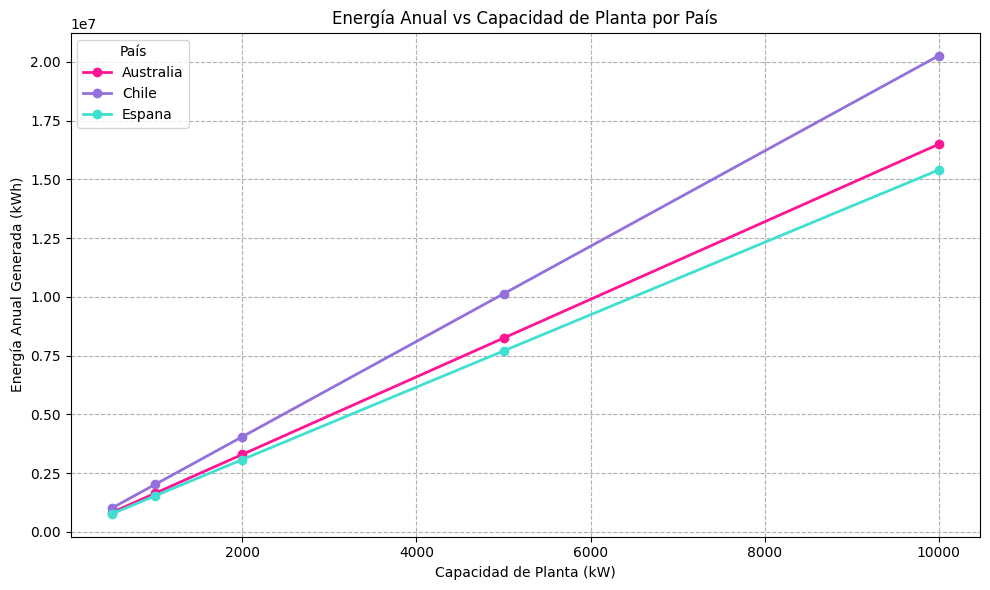


Gráfico comparativo Energía vs Capacidad guardado en: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_pv/pv_energia_vs_capacidad_all_countries.png
Resultados numéricos Energía vs Capacidad guardados en: /home/nicole/UA/NicoleTorres/PRUEBA1/Resultados/resultados_pv_energia_vs_capacidad.csv


In [9]:
simular_comparativa_energia_capacidad(paises, plantas, output_dir_graphs, output_dir_results)

# 2. Análisis de Sensibilidad de Inclinación (Configuración Fija 1MW)


--- Iniciando Análisis de Sensibilidad de Inclinación ---
  Calculando sensibilidad de inclinación para Australia (Azimuth: 0°)...
  Calculando sensibilidad de inclinación para Chile (Azimuth: 0°)...
  Calculando sensibilidad de inclinación para Espana (Azimuth: 180°)...
---------------------Gráfico de sensibilidad de inclinación-------------------


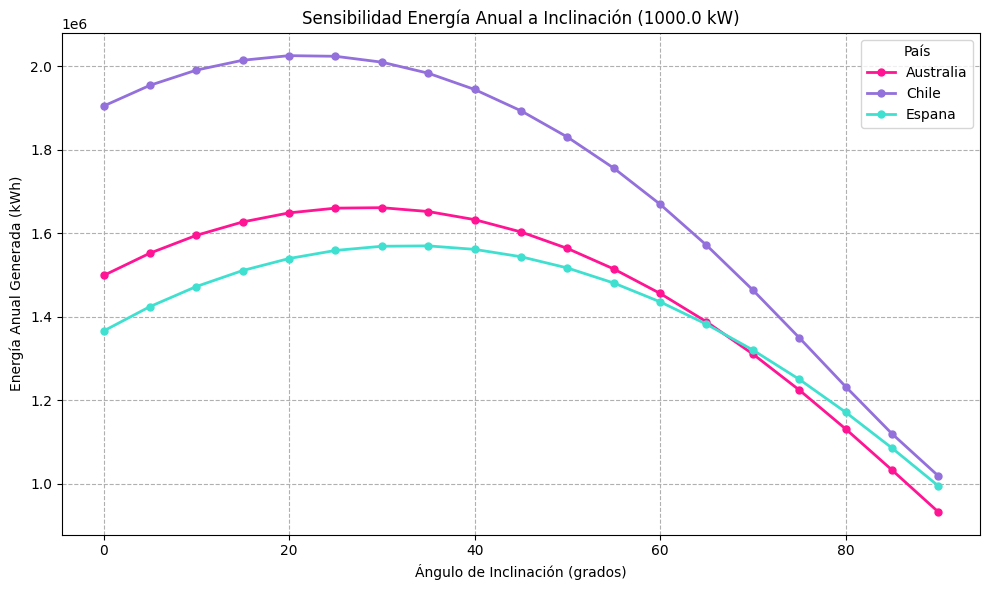


Gráfico de sensibilidad de inclinación guardado en: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_pv/tilt_sensitivity_all_countries_1000kW.png
Resultados numéricos Sensibilidad Inclinación guardados en: /home/nicole/UA/NicoleTorres/PRUEBA1/Resultados/resultados_pv_sensibilidad_tilt_1000kW.csv


In [10]:
analizar_sensibilidad_inclinacion(paises, output_dir_graphs, output_dir_results,config_sens_tilt)

# 3. Comparación de Azimut (Configuración Fija 1MW, Tilt 20°)


--- Iniciando Comparación de Azimut (0° vs 180°) ---
  Calculando comparación de azimut para Australia...
  Calculando comparación de azimut para Chile...
  Calculando comparación de azimut para Espana...
----------------------------Gráfico de comparación de azimut----------------------------


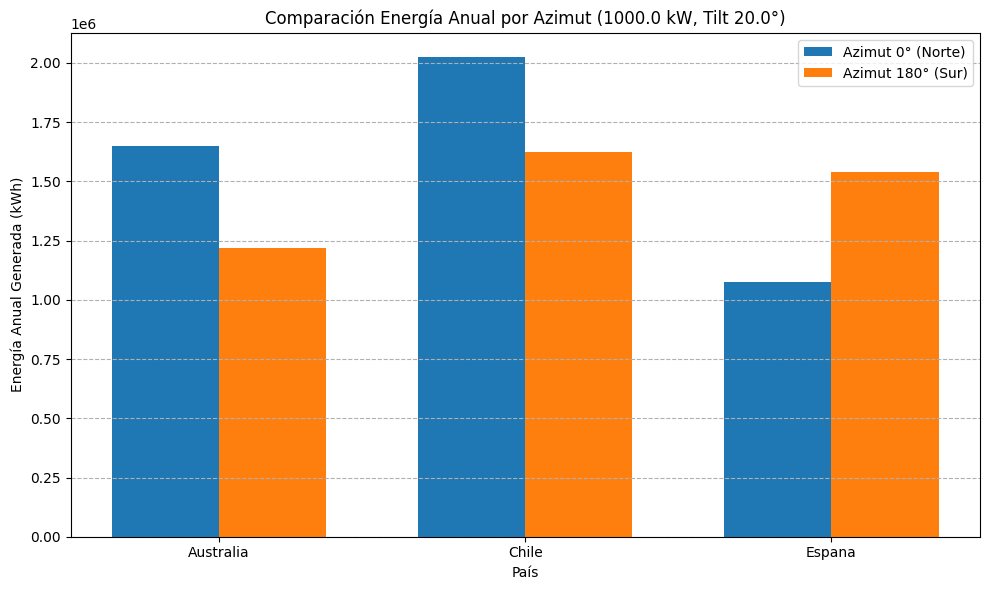


Gráfico de comparación de azimut guardado en: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_pv/azimuth_comparison_1000kW_tilt20.png
Resultados numéricos Comparación Azimut guardados en: /home/nicole/UA/NicoleTorres/PRUEBA1/Resultados/resultados_pv_comparacion_azimut_1000kW_tilt20.csv


In [11]:
comparar_azimut(paises, output_dir_graphs, output_dir_results, config_azimut)

# 4. Análisis de Sensibilidad del  DC/AC Ratio (Configuración Fija 1MW, Tilt 20°)


--- Iniciando Análisis de Sensibilidad del Ratio DC/AC ---
  Calculando sensibilidad DC/AC para Australia (Azimuth: 0°)...
  Calculando sensibilidad DC/AC para Chile (Azimuth: 0°)...
  Calculando sensibilidad DC/AC para Espana (Azimuth: 180°)...
----------------------------Gráfico de sensibilidad DC/AC----------------------------


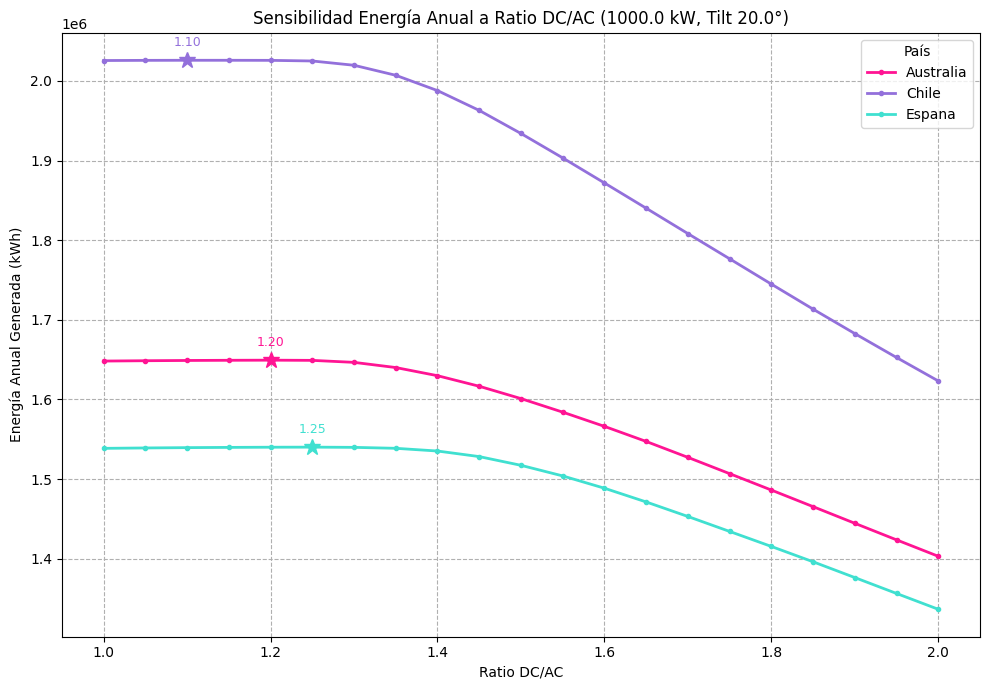


Gráfico de sensibilidad DC/AC guardado en: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_pv/dcac_sensitivity_all_countries_1000kW_tilt20.png
Resultados numéricos Sensibilidad DC/AC guardados en: /home/nicole/UA/NicoleTorres/PRUEBA1/Resultados/resultados_pv_sensibilidad_dcac_1000kW_tilt20.csv


In [12]:
analizar_sensibilidad_dcac(paises, output_dir_graphs, output_dir_results, config_dcac)

# ANÁLISIS ECONÓMICO

In [13]:
analizar_lcoe_vs_fcr(paises, output_dir_graphs, output_dir_results, config_lcoe_base)


--- Iniciando Análisis LCOE vs FCR ---
  Calculando LCOE vs FCR para Australia...
  Calculando LCOE vs FCR para Chile...
  Calculando LCOE vs FCR para Espana...
---------------------------Gráfico de LCOE vs FCR---------------------------

Gráfico combinado LCOE vs FCR guardado en: /home/nicole/UA/NicoleTorres/PRUEBA1/graficos/simulacion_pv/lcoe_vs_fcr_all_countries_1000kW.png
Resultados numéricos LCOE vs FCR guardados en: /home/nicole/UA/NicoleTorres/PRUEBA1/Resultados/resultados_pv_lcoe_vs_fcr_1000kW.csv


In [14]:
analizar_sensibilidad_lcoe(paises, output_dir_graphs, output_dir_results,  config_lcoe_base, lcoe_sens_ranges)

TypeError: analizar_sensibilidad_lcoe() missing 1 required positional argument: 'param_values'